Using FBProphet to make predictions on daily users in Google Calendar

In [2]:

%matplotlib inline
from fbprophet import Prophet

In [3]:
from dateutil.parser import parse
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

Reads csv and set time as index

In [36]:
df = pd.read_csv('C:\\Users\\Henry\\Documents\\405-DataScience\\G_Suite_Metrics\\src\\Jackie\\Gcalender.csv')
def time_set(df):
    import datetime as dt
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]],utc = True)
    df[df.columns[0]]= df.time.dt.date
    df.set_index(df.columns[0], inplace=True)
    return df


Plot the data for both predicted and actual

In [6]:
def plot(df,df0):
    df1 = df.copy()
    df2 = df0.copy()
    df1 = time_set(df1)
    df2 = time_set(df2)
    for x in range(len(df1.columns)):
        plt.figure(figsize=(22, 10))
        plt.plot(df1.index, df1[df1.columns[x]], label=df1.columns[x])
        plt.plot(df2.index, df2[df2.columns[x]], label='Prophet', color='r')
        plt.legend(loc='best', fontsize='xx-large')
        plt.show()

Time prediction function

In [42]:
def timeprediction123(df,csvfilename):
    p = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.3)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast

    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='740 days', period='100 days', horizon = '365 days')
    
    df_p = performance_metrics(df_cv)
    print("Performance head for " + csvfilename)
    print(df_p.head())
    print("Performance tail for " + csvfilename)
    print(df_p.tail())

    
    #df1.to_csv(data_path_write + csvfilename)
    df2 = time_pred[['yhat']]
    p.plot(time_pred)
    p.plot_components(time_pred)
    return df1,df2,time_pred

Time prediction with MAPE graph

In [43]:
def timepredictionMAPE(df,csvfilename):
    p = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.3)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast

    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='740 days', period='180 days', horizon = '365 days')
    try:
        print("MAPE for " + csvfilename + " predictions")
        fig = plot_cross_validation_metric(df_cv, metric='mape')
    except:
        print("MAPE way too low to be graphed, prediction is very good")
    df2 = time_pred[['yhat']]
    return df1,df2,time_pred

Function to visualize the predicted values

In [15]:
def send_prediction(df):
    df_with_all_preds = timeprediction123(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : df.columns[1]})
    df1= df.drop(columns= [df.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timeprediction123(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

In [16]:
def send_predictionMAPE(df):
    df_with_all_preds = timepredictionMAPE(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : df.columns[1]})
    df1= df.drop(columns= [df.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timepredictionMAPE(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2017-04-04 00:00:00 and 2018-08-17 00:00:00


Performance head for google.calendar:num_1day_active_users
  horizon           mse        rmse         mae      mape  coverage
0 37 days  92104.434392  303.487124  187.054005  0.166808  0.899522
1 38 days  90369.582630  300.615340  185.700728  0.165613  0.901914
2 39 days  89751.582112  299.585684  186.306338  0.166243  0.904306
3 40 days  90197.267678  300.328600  186.914255  0.166163  0.899522
4 41 days  90931.224128  301.548046  189.140416  0.167453  0.899522
Performance tail for google.calendar:num_1day_active_users
     horizon            mse        rmse         mae      mape  coverage
324 361 days  510087.577413  714.204157  567.691293  0.354532  0.429027
325 362 days  508294.032087  712.947426  563.562100  0.352015  0.441786
326 363 days  510812.606621  714.711555  562.775752  0.346837  0.446571
327 364 days  508218.205024  712.894245  558.645520  0.337998  0.448166
328 365 days  504195.513001  710.067259  554.658498  0.330754  0.456140


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2017-04-04 00:00:00 and 2018-08-17 00:00:00


Performance head for google.calendar:num_30day_active_users
  horizon           mse         rmse          mae      mape  coverage
0 37 days  2.397016e+06  1548.229809  1070.946304  0.118988  0.145933
1 38 days  2.417366e+06  1554.788199  1086.436498  0.122338  0.138756
2 39 days  2.427469e+06  1558.033680  1098.334021  0.125214  0.133971
3 40 days  2.439398e+06  1561.857315  1110.080261  0.128090  0.131579
4 41 days  2.459813e+06  1568.379061  1122.878785  0.131283  0.129187
Performance tail for google.calendar:num_30day_active_users
     horizon           mse         rmse          mae      mape  coverage
324 361 days  8.562844e+06  2926.233803  2413.589155  0.306724       1.0
325 362 days  8.773540e+06  2962.016158  2436.893975  0.309301       1.0
326 363 days  9.017810e+06  3002.966811  2463.333531  0.312261       1.0
327 364 days  9.270320e+06  3044.720079  2491.286387  0.315402       1.0
328 365 days  9.532271e+06  3087.437624  2522.126378  0.318844       1.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2017-04-04 00:00:00 and 2018-08-17 00:00:00


Performance head for google.calendar:num_7day_active_users
  horizon           mse         rmse         mae      mape  coverage
0 37 days  2.181382e+06  1476.950400  767.683041  0.211391  0.610048
1 38 days  2.182766e+06  1477.418768  773.266281  0.215350  0.595694
2 39 days  2.200928e+06  1483.552361  779.517056  0.217419  0.586124
3 40 days  2.219717e+06  1489.871505  784.900030  0.219229  0.581340
4 41 days  2.243972e+06  1497.989328  790.252591  0.221223  0.576555
Performance tail for google.calendar:num_7day_active_users
     horizon           mse         rmse          mae      mape  coverage
324 361 days  3.421008e+06  1849.596593  1132.739804  0.243612  0.995215
325 362 days  3.596576e+06  1896.464169  1144.065510  0.246275  0.995215
326 363 days  3.788017e+06  1946.282867  1157.641579  0.249582  0.995215
327 364 days  3.986556e+06  1996.636098  1173.384607  0.253468  0.995215
328 365 days  4.187042e+06  2046.226274  1189.385474  0.257611  0.996810


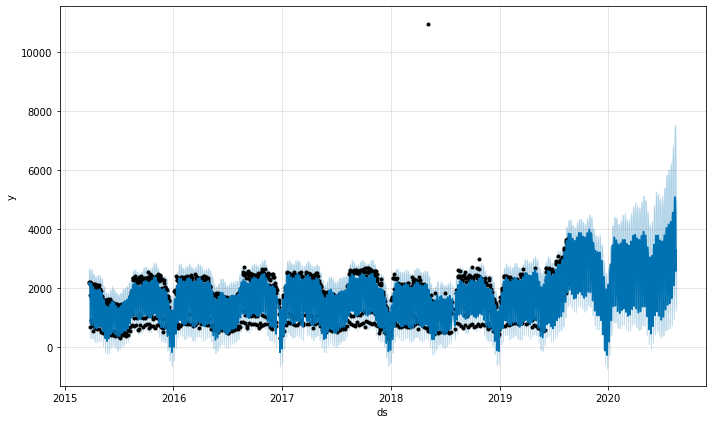

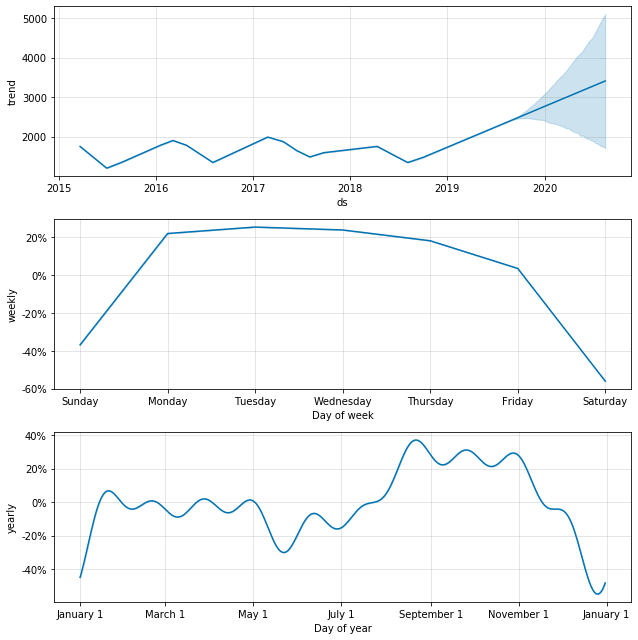

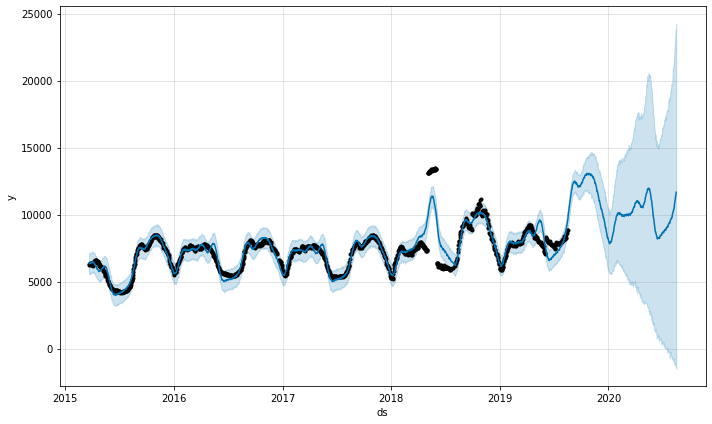

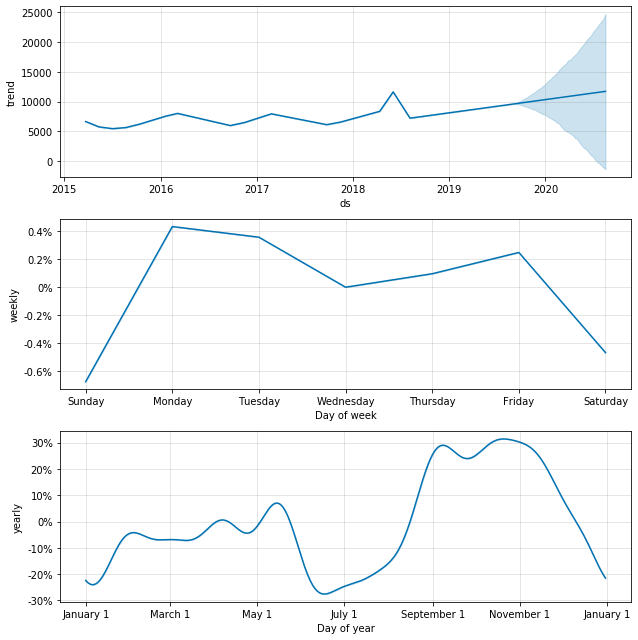

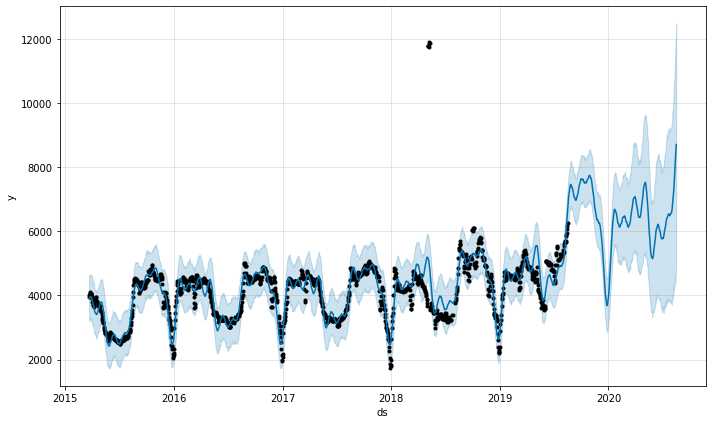

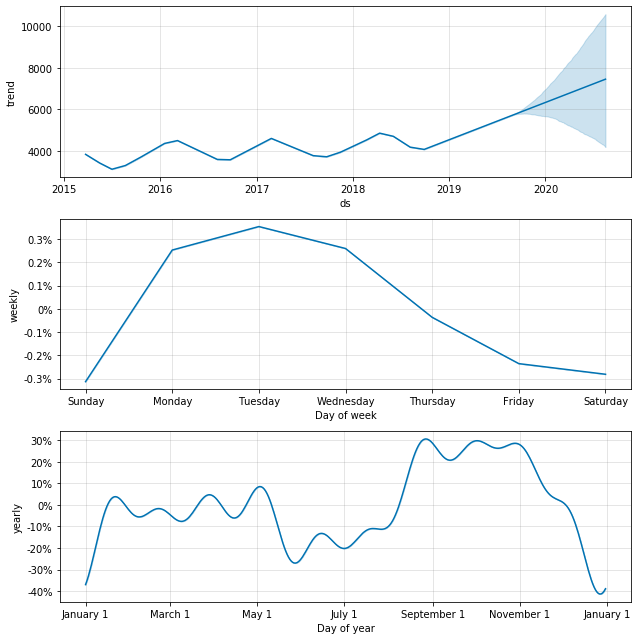

In [44]:
prediction = send_prediction(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-08-22 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE for google.calendar:num_1day_active_users predictions


INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-08-22 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE for google.calendar:num_30day_active_users predictions


INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-08-22 00:00:00 and 2018-08-17 00:00:00


MAPE for google.calendar:num_7day_active_users predictions


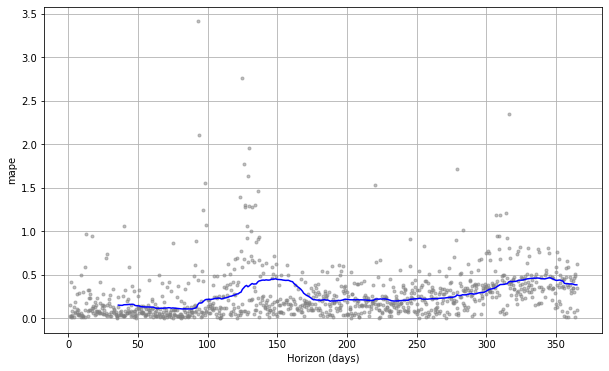

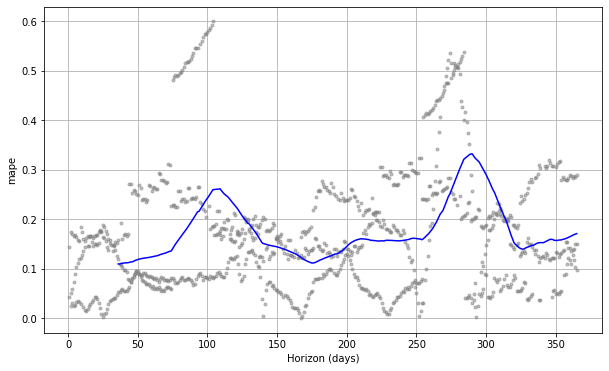

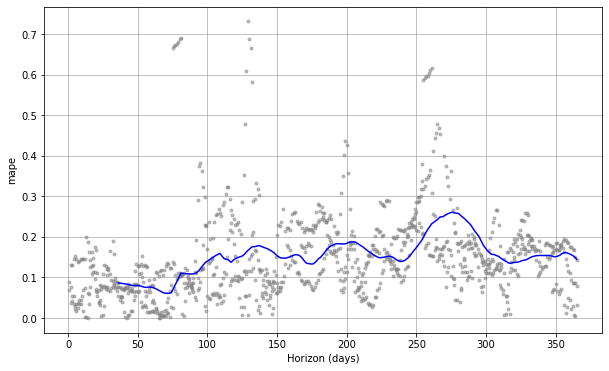

In [45]:
prediction1 = send_predictionMAPE(df)

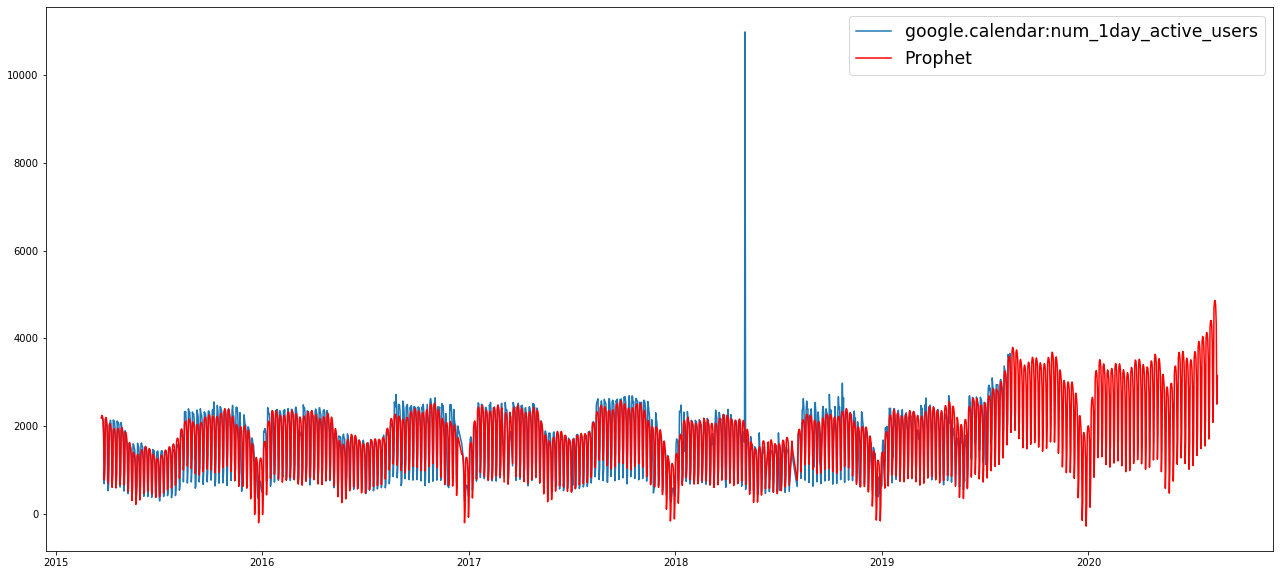

In [12]:
plot(df,prediction)

In [16]:
prediction.to_csv("PredictionCSV.csv", encoding='utf-8', index=True)
